## Prediction w/ Toy Example - m_params

Shows how matrices are built, and basic implementation of prediction methods

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('toy_data2.csv')
df.head(len(df))

,defense,player,pts
0,Defense_A,Player_W,20
1,Defense_A,Player_X,21
2,Defense_A,Player_Y,5
3,Defense_B,Player_W,23
4,Defense_B,Player_X,24
5,Defense_B,Player_Y,25
6,Defense_C,Player_W,19
7,Defense_C,Player_X,24
8,Defense_C,Player_Y,29


In [3]:
def bipartite_draw(G, nodes=None, label_pos=0.4):
    temp_G = G.copy()
    
    if nodes:
        for n in G:
            if n not in nodes:
                temp_G.remove_node(n)
    
    # need this to draw weights later
    pos = nx.spring_layout(temp_G)

    # Separate by group (uses original graph because temp_G may not be able to differentiate)
    l, r = nx.bipartite.sets(G)
    pos = {}

    # Update position for node from each group
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))

    nx.draw(temp_G, pos=pos, with_labels=True)
    nx.draw_networkx_edge_labels(temp_G, pos, label_pos=label_pos)
        
    plt.show()

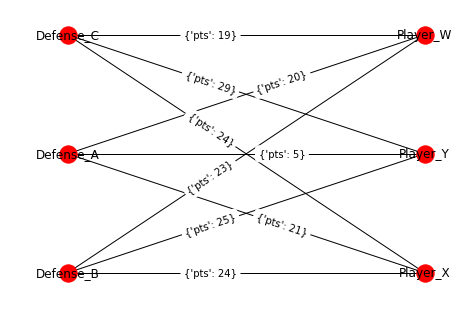

In [4]:
G = nx.from_pandas_edgelist(df, 'defense', 'player', ['pts']).to_undirected()

bipartite_draw(G)

In [5]:
def generate_triangle_dict(G, edge, edge_list):
    defense, player = split_edge(edge)
    
    triangle_dict = {}

    #print(defense)
    
    for player_other in G[defense]:
        if player_other != player:
            for defense_other in G[player_other]:
                if defense_other != defense and player in G[defense_other]:
                    
                    edge_key = (player_other, defense_other)
                    if edge_key not in edge_list:
                        edge_key = (defense_other, player_other)
                    
                    other_other = G[defense_other][player_other]['pts']
                    this_other = G[defense_other][player]['pts']
                    other_this = G[defense][player_other]['pts']
                    
                    predicted = (this_other/other_other) * other_this
                                        
                    triangle_dict[edge_key] = predicted
                        
    return triangle_dict  
    
def split_edge(edge):
    if 'Defense' in edge[0]:
        return (edge[0], edge[1])
    return (edge[1], edge[0])

### Note:
Each edge has 4 triangles - in real situation, each edge will have varying number of triangles. 

3 things that will have to be decided or tested are the number of triangles that are pulled out for each edge (m), how these m triangles are decided, and how the m triangles are ranked (from T1 to Tm).

In [6]:
edge_list = list(G.edges())
for edge in edge_list:
    print(edge)
    print('--------------------')
    print(generate_triangle_dict(G, edge, edge_list))
    print('\n')

('Defense_A', 'Player_W')
--------------------
{('Player_X', 'Defense_B'): 20.125, ('Player_X', 'Defense_C'): 16.625, ('Player_Y', 'Defense_B'): 4.6000000000000005, ('Player_Y', 'Defense_C'): 3.275862068965517}


('Defense_A', 'Player_X')
--------------------
{('Player_W', 'Defense_B'): 20.869565217391305, ('Player_W', 'Defense_C'): 25.263157894736842, ('Player_Y', 'Defense_B'): 4.8, ('Player_Y', 'Defense_C'): 4.137931034482759}


('Defense_A', 'Player_Y')
--------------------
{('Player_W', 'Defense_B'): 21.73913043478261, ('Player_W', 'Defense_C'): 30.526315789473685, ('Player_X', 'Defense_B'): 21.875, ('Player_X', 'Defense_C'): 25.375}


('Player_W', 'Defense_B')
--------------------
{('Defense_A', 'Player_X'): 22.857142857142854, ('Player_X', 'Defense_C'): 19.0, ('Defense_A', 'Player_Y'): 100.0, ('Player_Y', 'Defense_C'): 16.379310344827587}


('Player_W', 'Defense_C')
--------------------
{('Defense_A', 'Player_X'): 22.857142857142854, ('Player_X', 'Defense_B'): 23.0, ('Defense_A',

### Build Matrices

pred_mat = Nxm matrix of predictions

actual = Nx1 matrix of actual values

(Will not change as parameters change)
Note: N = number of edges/games

In [7]:
import numpy as np

#m = 4
pred_rows = []
actual_rows = []

for edge in edge_list:
    # pred
    tri_dict = generate_triangle_dict(G, edge, edge_list)
    pred_list = list(tri_dict.values())
    pred_list.sort()
    pred_rows.append(np.array(pred_list))
    
    # actual
    defense, player = split_edge(edge)
    actual = G[defense][player]['pts']
    actual_rows.append(np.array([actual]))
    

In [8]:
np.set_printoptions(precision=2)

In [9]:
m_mat = np.vstack(pred_rows)

m_mat

array([[   3.28,    4.6 ,   16.62,   20.12],
       [   4.14,    4.8 ,   20.87,   25.26],
       [  21.74,   21.88,   25.38,   30.53],
       [  16.38,   19.  ,   22.86,  100.  ],
       [  22.86,   23.  ,   26.68,  116.  ],
       [  20.69,   24.15,   29.05,  105.  ],
       [  19.83,   19.95,   27.84,  121.8 ],
       [   5.71,    5.75,   29.  ,   35.11],
       [   4.75,    5.71,   20.65,   25.  ]])

In [10]:
actual_mat = np.vstack(actual_rows)

actual_mat

array([[20],
       [21],
       [ 5],
       [23],
       [19],
       [24],
       [24],
       [25],
       [29]])

## Implementation of different prediction methods

#### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

regr.fit(m_mat, actual_mat)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
regr.coef_

array([[-2.1 ,  0.94,  0.47,  0.16]])

In [19]:
regr.intercept_

array([ 13.58])

In [13]:
# obviously in practice will have separate, clean test data

regr.predict(m_mat)

array([[ 22.11],
       [ 23.32],
       [  5.4 ],
       [ 24.12],
       [ 18.68],
       [ 23.64],
       [ 23.67],
       [ 26.32],
       [ 22.75]])

#### Random Forest Regressor

Need to transform actual_mat from Nx1 to 1xN?

In [14]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor()

actual_mat.ravel()


array([20, 21,  5, 23, 19, 24, 24, 25, 29])

In [15]:
regr.fit(m_mat, actual_mat.ravel())

# no coef in this model
#regr.coef_

for x in regr.predict(m_mat):
    print(x)

21.8
20.9
15.0
23.9
16.2
20.2
22.4
24.7
27.7
